In [941]:
import pandas as pd
import numpy as np
import missingno as msno
import itertools
from copy import copy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.ensemble import VotingClassifier
# from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
# from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import Imputer
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from fancyimpute import KNN, MICE
from sklearn.svm import SVC
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
# from sklearn.decomposition import PCA
# from sklearn.cross_decomposition import PLSRegression
# from sklearn.metrics import f1_score
# from scipy.cluster.hierarchy import fcluster
# from scipy.cluster.hierarchy import dendrogram, ward
# from scipy.cluster.hierarchy import fcluster

# from xgboost import XGBClassifier
# from xgboost import plot_importance

In [958]:
def create_raw_data():
    train = pd.read_csv("train2016.csv", index_col="USER_ID")
    test = pd.read_csv("test2016.csv", index_col="USER_ID")
    return train, test


def split_X_y(train):
    y = train['Party']
    X = train.drop(['Party'], 1)
    return X, y


def rename_columns(train, test):
    def column_handler(col):
        new_col = question_key.get(col)
        if new_col != None:
            return new_col
        else:
            return col 
        
    questions = pd.read_csv("Questions.csv")
    pre_question_key = questions.set_index('Question ID ')['Simple ID '].to_dict()
    question_key = {"Q"+str(k):v for k, v in pre_question_key.items()}
    train = train.rename(columns=column_handler)
    test  = test.rename(columns=column_handler)
    return train, test

def drop_outliers(X, y):
    idx = (X.YOB > 1933) & (X.YOB < 2000)
    X = X[idx]
    y = y[idx]
    return X, y


def sampler(X, y, p = 1):
    """create a function that preserves samples greater or
    equal to the percentage of features that are not NAs"""
    X = X.dropna(thresh=X.shape[1] * (p))
    return X, y[X.index]

In [1045]:
def create_train_test_sets():
    train, Xtest = create_raw_data()
    USER_ID = Xtest.index
    
    Xtrain, ytrain = split_X_y(train)
    Xtrain, ytrain = drop_outliers(Xtrain, ytrain)
    Xtrain, Xtest = rename_columns(Xtrain, Xtest)
    
    col_names = list(Xtrain.columns)
    # place binary Gender feature with Question Features
    # Now all non-binary features are grouped
    # as the first four features
    col_names.insert(4, col_names.pop(1))
    col_names.insert(3, col_names.pop(2))
    
    # Rearrange columns for Xtrain and Xtest
    Xtrain = Xtrain[col_names]
    Xtest = Xtest[col_names]
    
    # Create categories for binary question features
    Xtrain = Xtrain.apply(lambda x: x.astype('category'))
    Xtest = Xtest.apply(lambda x: x.astype('category'))
    
    # Create categories for ordinal features
    Xtrain.Income = Xtrain.Income.cat.reorder_categories(['under $25,000',
                                                          '$25,001 - $50,000',
                                                          '$50,000 - $74,999',
                                                          '$75,000 - $100,000',
                                                          '$100,001 - $150,000',
                                                          'over $150,000'], ordered=True)
    
    Xtest.Income = Xtest.Income.cat.reorder_categories(['under $25,000',
                                                        '$25,001 - $50,000',
                                                        '$50,000 - $74,999',
                                                        '$75,000 - $100,000',
                                                        '$100,001 - $150,000',
                                                        'over $150,000'], ordered=True)
    
    Xtrain.EducationLevel = Xtrain.EducationLevel.cat.reorder_categories(['Current K-12',
                                                                          'High School Diploma',
                                                                          'Current Undergraduate',
                                                                          "Associate's Degree", 
                                                                          "Bachelor's Degree",
                                                                          "Master's Degree",
                                                                          'Doctoral Degree'], ordered=True)
    
    Xtest.EducationLevel = Xtest.EducationLevel.cat.reorder_categories(['Current K-12',
                                                                        'High School Diploma',
                                                                        'Current Undergraduate',
                                                                        "Associate's Degree", 
                                                                        "Bachelor's Degree",
                                                                        "Master's Degree",
                                                                        'Doctoral Degree'], ordered=True)
    
    return Xtrain, ytrain, Xtest

## Let's create our clean data set

In [1048]:
Xtrain, ytrain, Xtest = create_train_test_sets()

In [1049]:
print Xtrain.shape
print Xtrain_dummy.shape
print Xtrain_dummy_NA.shape

(5173, 106)
(5173, 106)
(5173, 394)


In [1052]:
Xtrain.iloc[:, :10].head()

,YOB,Income,EducationLevel,HouseholdStatus,Gender,Interact.with.someone.dislike.daily,Parents.Fight.in.front,Work.Min.Wage,Full.Time.Emp,Collect.anything.hobby
USER_ID,,,,,,,,,,
1,1938.0,NaN,NaN,Married (w/kids),Male,No,NaN,No,No,No
4,1970.0,"over $150,000",Bachelor's Degree,Domestic Partners (w/kids),Female,NaN,Yes,No,No,No
5,1997.0,"$75,000 - $100,000",High School Diploma,Single (no kids),Male,NaN,Yes,Yes,No,NaN
8,1983.0,"$100,001 - $150,000",Bachelor's Degree,Married (w/kids),Male,No,Yes,No,Yes,No
9,1984.0,"$50,000 - $74,999",High School Diploma,Married (w/kids),Female,No,Yes,No,No,No


# We will create a function that performs the following.

1) Reduce the amount of samples based on percentage threshold of NA per sample.

2) Impute continuous features while creating dummy categories for categorical features.

3) Test on support vector machine as representative baseline model.

In [400]:
def process(X, y=None, threshold=0.75, scale=False, dummy_na=True):
    if y is not None:
        X, y = sampler(X, y, p=threshold)
    continuous_cols = X.loc[:,'YOB':'EducationLevel'] 
    continuous_names = continuous_cols.columns
    continuous_index = continuous_cols.index
    continuous_cols.YOB = continuous_cols.YOB.astype('O')
    if scale:
        continuous_cols.YOB = 2016 - continuous_cols.YOB
        continuous_cols.rename(columns={'YOB': 'Age'})
    continuous_cols.loc[:, 'Income':'EducationLevel'] = (continuous_cols.loc[:, 'Income':'EducationLevel']
                                                         .apply(lambda x: x.cat.codes))
    continuous_cols = continuous_cols.replace(-1, np.nan)
    continuous_cols = MICE(verbose=False).complete(continuous_cols.values)
    if scale:
        continuous_cols += 1
        continuous_cols = MinMaxScaler().fit_transform(np.apply_along_axis(lambda x: boxcox(x)[0], 1, continuous_cols))
    continuous_cols = pd.DataFrame(continuous_cols, columns=continuous_names, index=continuous_index)
    
    if not y is not None:
        return pd.concat([continuous_cols, 
                      pd.get_dummies(X.loc[:, 'HouseholdStatus':], 
                                     dummy_na=dummy_na)], axis=1)
    
    return pd.concat([continuous_cols, 
                      pd.get_dummies(X.loc[:, 'HouseholdStatus':], 
                                     dummy_na=dummy_na)], axis=1), y

## Let's run some algorithms quickly too get a rough understanding of performance
## The data will contain all the samples with Mice imputation.
## We will compare both NA categories and without

In [1065]:
Xtrain_dummy, ytrain = process(Xtrain, ytrain, threshold=0, dummy_na=False)
Xtrain_dummy_NA, ytrain = process(Xtrain, ytrain, threshold=0, dummy_na=True)

# Initial tries

In [1066]:
np.random.seed(1234)
rf = RandomForestClassifier(n_estimators=50)
np.mean(cross_val_score(rf, Xtrain_dummy, ytrain == 'Republican', scoring='roc_auc'))

0.64614725053686961

In [1067]:
np.random.seed(1234)
rf = RandomForestClassifier(n_estimators=50)
np.mean(cross_val_score(rf, Xtrain_dummy_NA, ytrain == 'Republican', scoring='roc_auc'))

0.64801796708101034

In [1068]:
np.random.seed(1234)
gbm = GradientBoostingClassifier(n_estimators=50)
np.mean(cross_val_score(gbm, Xtrain_dummy, ytrain == 'Republican', scoring='roc_auc'))

0.67761455882213184

In [1069]:
np.random.seed(1234)
gbm = GradientBoostingClassifier(n_estimators=50)
np.mean(cross_val_score(gbm, Xtrain_dummy_NA, ytrain == 'Republican', scoring='roc_auc'))

0.67829416478781901

# Let's now model the scaled processed data set again with the linear models and support vector machines

In [1070]:
X_NA, y_NA = process(Xtrain, ytrain, threshold=0, scale=True, dummy_na=True)
X, y = process(Xtrain, ytrain, threshold=0, scale=True, dummy_na=False)

In [1079]:
np.random.seed(1234)
svc = SVC(gamma=0.01)
np.mean(cross_val_score(svc, X, y == 'Republican', scoring='roc_auc', cv=2))

0.66564780788566069

In [1080]:
np.random.seed(1234)
svc = SVC(gamma=0.01)
np.mean(cross_val_score(svc, X_NA, y_NA == 'Republican', scoring='roc_auc', cv=2))

0.65727919538444346

In [1073]:
np.random.seed(1234)
sgd = SGDClassifier(penalty='l1', alpha=0.01)
np.mean(cross_val_score(sgd, X, y == 'Republican', scoring='roc_auc', cv=2))

0.65773836528987339

In [1074]:
np.random.seed(1234)
sgd = SGDClassifier(penalty='l1', alpha=0.01)
np.mean(cross_val_score(sgd, X_NA, y_NA == 'Republican', scoring='roc_auc', cv=2))

0.65586093993379524

In [1075]:
np.random.seed(1234)
sgd = SGDClassifier(penalty='l2', alpha=0.1)
np.mean(cross_val_score(sgd, X, y == 'Republican', scoring='roc_auc', cv=2))

0.6689067273366478

In [1076]:
np.random.seed(1234)
sgd = SGDClassifier(penalty='l2', alpha=0.1)
np.mean(cross_val_score(sgd, X_NA, y_NA == 'Republican', scoring='roc_auc', cv=2))

0.66547899604163563

In [1077]:
np.random.seed(1234)
sgd = SGDClassifier(penalty='elasticnet', alpha=0.1)
np.mean(cross_val_score(sgd, X, y == 'Republican', scoring='roc_auc', cv=2))

0.66961827549394082

In [1078]:
np.random.seed(1234)
sgd = SGDClassifier(penalty='elasticnet', alpha=0.1)
np.mean(cross_val_score(sgd, X_NA, y_NA == 'Republican', scoring='roc_auc', cv=2))

0.66774885828797581

### Let's test our training data on several thresholds of filled questions.  We'll test Logistic Regression, SVM, Random Forests and Gradient Boosting as our base models to determine what threshold is optimal

In [765]:
threshold_scores = []
svc = SVC(gamma=0.01)
for threshold in np.arange(5, 100, 5)/100.:
    X, y = process(Xtrain, ytrain, threshold=threshold, scale=True, dummy_na=True)
    score = np.mean(cross_val_score(svc, X, y == 'Republican', 
                                    scoring='roc_auc', 
                                    cv=StratifiedShuffleSplit(test_size=0.5)))
    print threshold, score
    threshold_scores.append(score)

0.05 0.663681708391
0.1 0.66281530647
0.15 0.667688013035
0.2 0.675149516642
0.25 0.683224880657
0.3 0.68564128265
0.35 0.690917671563
0.4 0.689569305429
0.45 0.683171857356
0.5 0.68223973404
0.55 0.686458728064
0.6 0.683284349093
0.65 0.684172729572
0.7 0.68308841722
0.75 0.689326875556
0.8 0.691431740433
0.85 0.684946200927
0.9 0.680119015307
0.95 0.681822413731


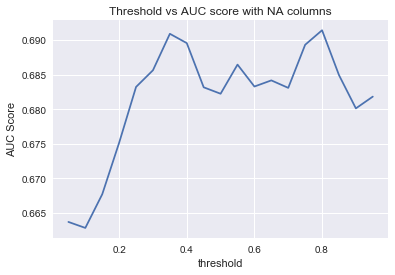

In [766]:
plt.plot(np.arange(5, 100, 5)/100., threshold_scores)
plt.title('Threshold vs AUC score with NA columns')
plt.xlabel('threshold')
plt.ylabel('AUC Score')
plt.savefig('images/fig1');

In [767]:
threshold_scores = []
svc = SVC()
for threshold in np.arange(5, 100, 5)/100.:
    X, y = process(Xtrain, ytrain, threshold=threshold, scale=True, dummy_na=False)
    score = np.mean(cross_val_score(svc, X, y == 'Republican', 
                                    scoring='roc_auc', 
                                    cv=StratifiedShuffleSplit(test_size=0.5)))
    print threshold, score
    threshold_scores.append(score)

0.05 0.672366459451
0.1 0.677970570523
0.15 0.676414728167
0.2 0.687244573944
0.25 0.691291578575
0.3 0.692334148481
0.35 0.700741815173
0.4 0.695362324335
0.45 0.69395597052
0.5 0.699497708694
0.55 0.686297351331
0.6 0.69047459893
0.65 0.689966455519
0.7 0.691099073943
0.75 0.690954581398
0.8 0.68775800877
0.85 0.685548644502
0.9 0.681391418067
0.95 0.684347509519


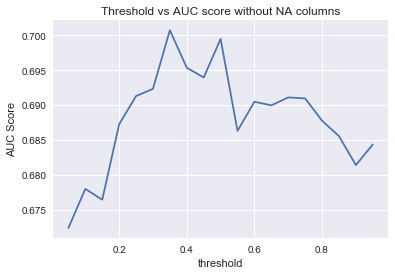

In [768]:
plt.plot(np.arange(5, 100, 5)/100., threshold_scores)
plt.title('Threshold vs AUC score without NA columns')
plt.xlabel('threshold')
plt.ylabel('AUC Score')
plt.savefig('images/fig2');

In [769]:
threshold_scores = []
gbm = GradientBoostingClassifier(n_estimators=50)
for threshold in np.arange(5, 100, 5)/100.:
    X, y = process(Xtrain, ytrain, threshold=threshold, dummy_na=True)
    score = np.mean(cross_val_score(gbm, X, y == 'Republican', 
                                    scoring='roc_auc', 
                                    cv=StratifiedShuffleSplit(test_size=0.5)))
    print threshold, score
    threshold_scores.append(score)

0.05 0.677019296022
0.1 0.681679856256
0.15 0.680975514547
0.2 0.68794973315
0.25 0.690237202361
0.3 0.694326422235
0.35 0.698422100003
0.4 0.698772242443
0.45 0.69435856941
0.5 0.701465436562
0.55 0.689675972507
0.6 0.689960706505
0.65 0.693768882249
0.7 0.68728107769
0.75 0.689281407532
0.8 0.698029381461
0.85 0.697155458941
0.9 0.687739860669
0.95 0.678852695783


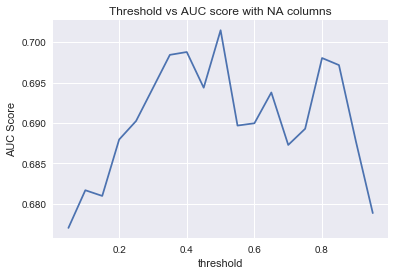

In [770]:
plt.plot(np.arange(5, 100, 5)/100., threshold_scores)
plt.title('Threshold vs AUC score with NA columns')
plt.xlabel('threshold')
plt.ylabel('AUC Score')
plt.savefig('images/fig3gbm');

In [771]:
threshold_scores = []
gbm = GradientBoostingClassifier(n_estimators=50)
for threshold in np.arange(5, 100, 5)/100.:
    X, y = process(Xtrain, ytrain, threshold=threshold, dummy_na=False)
    score = np.mean(cross_val_score(gbm, X, y == 'Republican', 
                                    scoring='roc_auc', 
                                    cv=StratifiedShuffleSplit(test_size=0.5)))
    print threshold, score
    threshold_scores.append(score)

0.05 0.677478415782
0.1 0.681489965439
0.15 0.680305267523
0.2 0.697373928428
0.25 0.702243449312
0.3 0.697362141819
0.35 0.699524655275
0.4 0.700077595794
0.45 0.692903512648
0.5 0.699489497766
0.55 0.699743887938
0.6 0.696330072433
0.65 0.692888413136
0.7 0.693707585183
0.75 0.697760452703
0.8 0.690812133861
0.85 0.690942469621
0.9 0.690352933435
0.95 0.685295241051


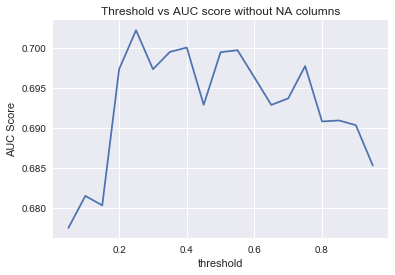

In [773]:
plt.plot(np.arange(5, 100, 5)/100., threshold_scores)
plt.title('Threshold vs AUC score without NA columns')
plt.xlabel('threshold')
plt.ylabel('AUC Score')
plt.savefig('images/fig4gbm');

In [774]:
threshold_scores = []
rf = RandomForestClassifier(n_estimators=50)
for threshold in np.arange(5, 100, 5)/100.:
    X, y = process(Xtrain, ytrain, threshold=threshold, dummy_na=True)
    score = np.mean(cross_val_score(rf, X, y == 'Republican', 
                                    scoring='roc_auc', 
                                    cv=StratifiedShuffleSplit(test_size=0.5)))
    print threshold, score
    threshold_scores.append(score)

0.05 0.640479104083
0.1 0.635433980049
0.15 0.648471596225
0.2 0.658318546604
0.25 0.661016540548
0.3 0.662051121217
0.35 0.671749430797
0.4 0.6644390734
0.45 0.668083127397
0.5 0.670650894865
0.55 0.669530423108
0.6 0.670452069717
0.65 0.674078997155
0.7 0.675857132758
0.75 0.672349881388
0.8 0.676555585512
0.85 0.68785552621
0.9 0.685926666173
0.95 0.685410126643


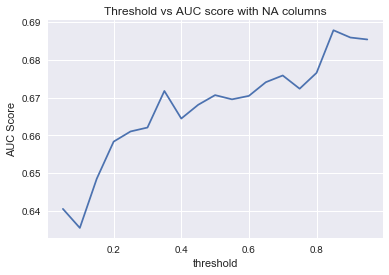

In [775]:
plt.plot(np.arange(5, 100, 5)/100., threshold_scores)
plt.title('Threshold vs AUC score with NA columns')
plt.xlabel('threshold')
plt.ylabel('AUC Score')
plt.savefig('images/fig5rf');

In [776]:
threshold_scores = []
rf = RandomForestClassifier(n_estimators=50)
for threshold in np.arange(5, 100, 5)/100.:
    X, y = process(Xtrain, ytrain, threshold=threshold, dummy_na=False)
    score = np.mean(cross_val_score(rf, X, y == 'Republican', 
                                    scoring='roc_auc', 
                                    cv=StratifiedShuffleSplit(test_size=0.5)))
    print threshold, score
    threshold_scores.append(score)

0.05 0.644908559781
0.1 0.645959927212
0.15 0.652178690233
0.2 0.665431365192
0.25 0.668679339143
0.3 0.672309958932
0.35 0.673464621258
0.4 0.679102530078
0.45 0.682428713266
0.5 0.672510073381
0.55 0.671237374067
0.6 0.673114902527
0.65 0.680435392074
0.7 0.683143534391
0.75 0.679307971731
0.8 0.685759979148
0.85 0.675430044636
0.9 0.677455564603
0.95 0.676724775898


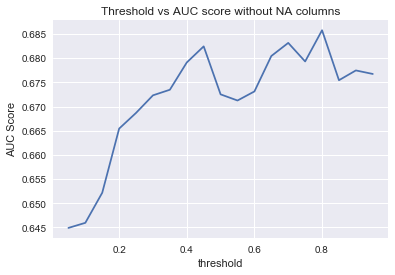

In [777]:
plt.plot(np.arange(5, 100, 5)/100., threshold_scores)
plt.title('Threshold vs AUC score without NA columns')
plt.xlabel('threshold')
plt.ylabel('AUC Score')
plt.savefig('images/fig6rf');

In [778]:
threshold_scores = []
sgd = SGDClassifier(penalty='l1', alpha=0.01)
for threshold in np.arange(5, 100, 5)/100.:
    X, y = process(Xtrain, ytrain, threshold=threshold, scale=True, dummy_na=True)
    score = np.mean(cross_val_score(sgd, X, y == 'Republican', 
                                    scoring='roc_auc', 
                                    cv=StratifiedShuffleSplit(test_size=0.5)))
    print threshold, score
    threshold_scores.append(score)

0.05 0.662771657188
0.1 0.667796258477
0.15 0.671564864091
0.2 0.681806944112
0.25 0.689718217562
0.3 0.693852379116
0.35 0.692220520458
0.4 0.696531126782
0.45 0.69337532527
0.5 0.691300657004
0.55 0.698779139281
0.6 0.698847190391
0.65 0.692850673144
0.7 0.701648323731
0.75 0.705091306711
0.8 0.698619444945
0.85 0.695105063111
0.9 0.689271761213
0.95 0.687070745652


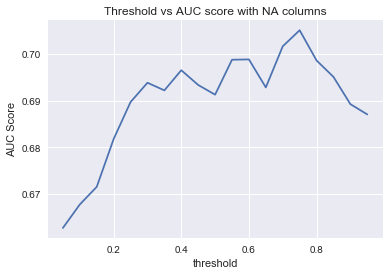

In [779]:
plt.plot(np.arange(5, 100, 5)/100., threshold_scores)
plt.title('Threshold vs AUC score with NA columns')
plt.xlabel('threshold')
plt.ylabel('AUC Score')
plt.savefig('images/fig7sgdL1');

In [780]:
threshold_scores = []
sgd = SGDClassifier(penalty='l1', alpha=0.01)
for threshold in np.arange(5, 100, 5)/100.:
    X, y = process(Xtrain, ytrain, threshold=threshold, scale=True, dummy_na=False)
    score = np.mean(cross_val_score(sgd, X, y == 'Republican', 
                                    scoring='roc_auc', 
                                    cv=StratifiedShuffleSplit(test_size=0.5)))
    print threshold, score
    threshold_scores.append(score)

0.05 0.662246154664
0.1 0.667911953761
0.15 0.673901357171
0.2 0.685573085456
0.25 0.690051037491
0.3 0.689403059559
0.35 0.698563974653
0.4 0.698208345971
0.45 0.694655404263
0.5 0.701503653563
0.55 0.696343379634
0.6 0.701569794585
0.65 0.69624795861
0.7 0.703583168387
0.75 0.694421394682
0.8 0.702852342256
0.85 0.689327834683
0.9 0.689104383086
0.95 0.677488690483


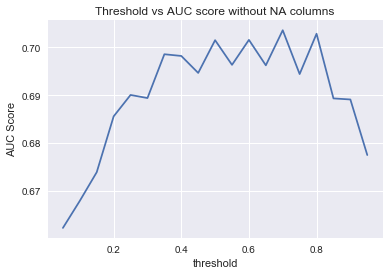

In [781]:
plt.plot(np.arange(5, 100, 5)/100., threshold_scores)
plt.title('Threshold vs AUC score without NA columns')
plt.xlabel('threshold')
plt.ylabel('AUC Score')
plt.savefig('images/fig8sgdL1');

In [782]:
threshold_scores = []
sgd = SGDClassifier(penalty='l2', alpha=0.1)
for threshold in np.arange(5, 100, 5)/100.:
    X, y = process(Xtrain, ytrain, threshold=threshold, scale=True, dummy_na=True)
    score = np.mean(cross_val_score(sgd, X, y == 'Republican', 
                                    scoring='roc_auc', 
                                    cv=StratifiedShuffleSplit(test_size=0.5)))
    print threshold, score
    threshold_scores.append(score)

0.05 0.666754260492
0.1 0.670732071322
0.15 0.674094469189
0.2 0.674627090436
0.25 0.687517865514
0.3 0.687553348393
0.35 0.691072769823
0.4 0.69052838439
0.45 0.689326628807
0.5 0.689655793892
0.55 0.689720073436
0.6 0.694406070509
0.65 0.678851096616
0.7 0.680488190124
0.75 0.680547346051
0.8 0.688326333697
0.85 0.691631733997
0.9 0.686019197078
0.95 0.688993065088


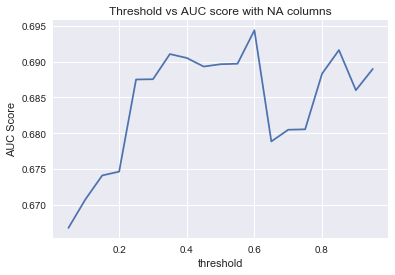

In [783]:
plt.plot(np.arange(5, 100, 5)/100., threshold_scores)
plt.title('Threshold vs AUC score with NA columns')
plt.xlabel('threshold')
plt.ylabel('AUC Score')
plt.savefig('images/fig9sgdL2');

In [784]:
threshold_scores = []
sgd = SGDClassifier(penalty='l2', alpha=0.1)
for threshold in np.arange(5, 100, 5)/100.:
    X, y = process(Xtrain, ytrain, threshold=threshold, scale=True, dummy_na=False)
    score = np.mean(cross_val_score(sgd, X, y == 'Republican', 
                                    scoring='roc_auc', 
                                    cv=StratifiedShuffleSplit(test_size=0.5)))
    print threshold, score
    threshold_scores.append(score)

0.05 0.673460188772
0.1 0.674651114078
0.15 0.679263296467
0.2 0.686759150418
0.25 0.694029139681
0.3 0.691339547953
0.35 0.698682810834
0.4 0.695273860075
0.45 0.689453736587
0.5 0.69380122564
0.55 0.696963896039
0.6 0.690685655575
0.65 0.68903913
0.7 0.688431579598
0.75 0.688876396165
0.8 0.694879099546
0.85 0.697261830991
0.9 0.684233144982
0.95 0.677996872725


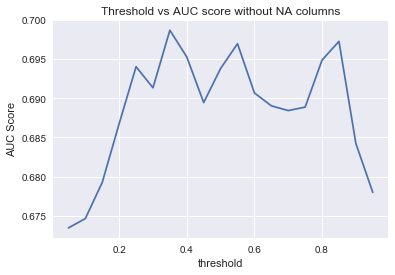

In [785]:
plt.plot(np.arange(5, 100, 5)/100., threshold_scores)
plt.title('Threshold vs AUC score without NA columns')
plt.xlabel('threshold')
plt.ylabel('AUC Score')
plt.savefig('images/fig10sgdL2');

In [786]:
threshold_scores = []
sgd = SGDClassifier(penalty='elasticnet', alpha=0.1)
for threshold in np.arange(5, 100, 5)/100.:
    X, y = process(Xtrain, ytrain, threshold=threshold, scale=True, dummy_na=True)
    score = np.mean(cross_val_score(sgd, X, y == 'Republican', 
                                    scoring='roc_auc', 
                                    cv=StratifiedShuffleSplit(test_size=0.5)))
    print threshold, score
    threshold_scores.append(score)

0.05 0.665868804452
0.1 0.664228589008
0.15 0.678297404315
0.2 0.689897623051
0.25 0.691181563364
0.3 0.699662903848
0.35 0.700420334504
0.4 0.707986111111
0.45 0.709406862184
0.5 0.700656086162
0.55 0.70621961936
0.6 0.709746537504
0.65 0.706689193031
0.7 0.704446044818
0.75 0.711340688939
0.8 0.704271408125
0.85 0.707919747093
0.9 0.701969674538
0.95 0.703117129591


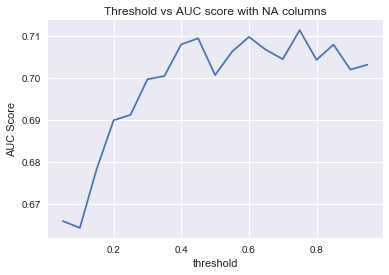

In [787]:
plt.plot(np.arange(5, 100, 5)/100., threshold_scores)
plt.title('Threshold vs AUC score with NA columns')
plt.xlabel('threshold')
plt.ylabel('AUC Score')
plt.savefig('images/fig11sgdenet');

In [788]:
threshold_scores = []
sgd = SGDClassifier(penalty='elasticnet', alpha=0.1)
for threshold in np.arange(5, 100, 5)/100.:
    X, y = process(Xtrain, ytrain, threshold=threshold, scale=True, dummy_na=False)
    score = np.mean(cross_val_score(sgd, X, y == 'Republican', 
                                    scoring='roc_auc', 
                                    cv=StratifiedShuffleSplit(test_size=0.5)))
    print threshold, score
    threshold_scores.append(score)

0.05 0.67063138258
0.1 0.669300820831
0.15 0.685315517145
0.2 0.694814547733
0.25 0.694879270264
0.3 0.705263054728
0.35 0.706434080007
0.4 0.705486742999
0.45 0.699309362879
0.5 0.710160022424
0.55 0.707428393158
0.6 0.709436539767
0.65 0.702365562306
0.7 0.705895328185
0.75 0.703758154591
0.8 0.705379422363
0.85 0.708231407259
0.9 0.712047112625
0.95 0.701840855107


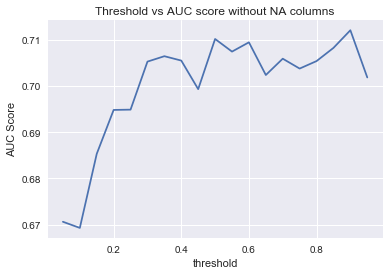

In [789]:
plt.plot(np.arange(5, 100, 5)/100., threshold_scores)
plt.title('Threshold vs AUC score without NA columns')
plt.xlabel('threshold')
plt.ylabel('AUC Score')
plt.savefig('images/fig12enet');

### It seems that whetherWe'll use a threshold of 0.3 for our threshold for data.  This conveniently remove the outlier samples that imputation can't reasonably impute well.  While attempting to keep most of the data as possible.  We also 
### Now we'll use randomized grid search to determine the approximate optimal paramters

### It seems that whetherWe'll use a threshold of 0.3 for our threshold for data.  This conveniently remove the outlier samples that imputation can't reasonably impute well.  While attempting to keep most of the data as possible.  We also 
### Now we'll use randomized grid search to determine the approximate optimal paramters while utilizing training sets that include dummy variables for NAs since it provides more features and doesn't seem to deter the cross validation accuracy

# Some Visualizations

# Sparsity Matrix

Here is a plot of the dataframe showing the sparsity of the dataset

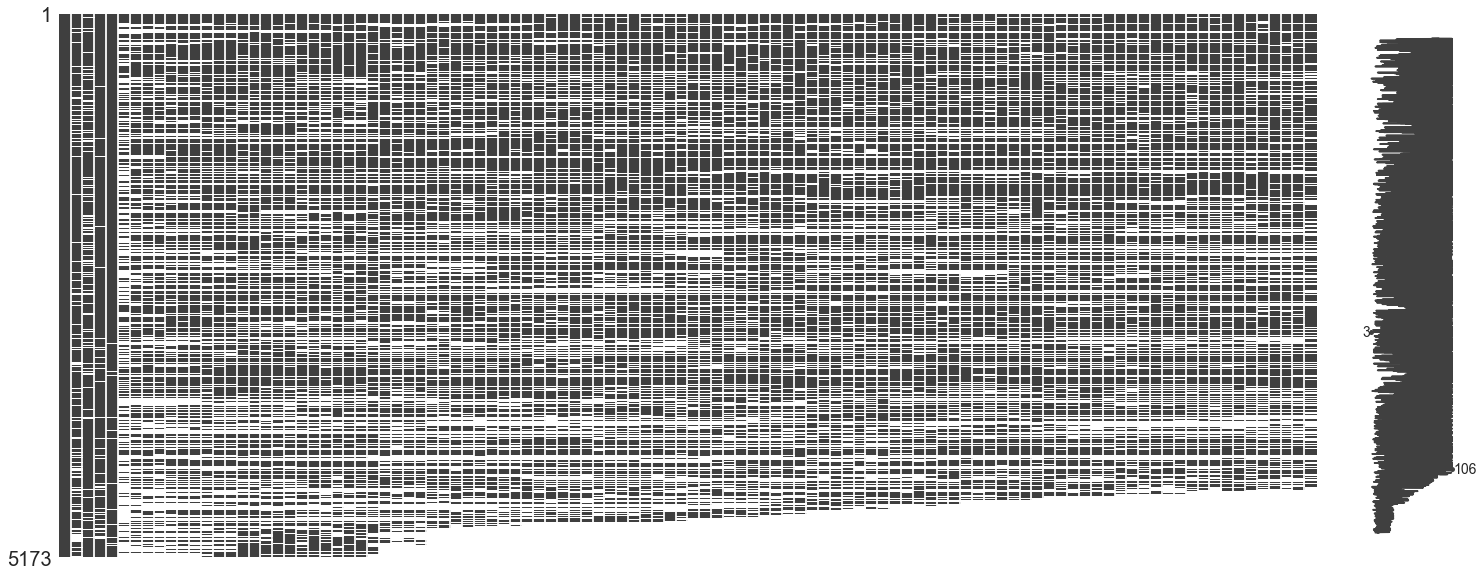

In [637]:
x = msno.heatmap(Xtrain, inline=False)
x.savefig('images/matrix2')

Let's explore which features has the greatest odds ratio for each party

In [1096]:
X = Xtrain.loc[:, 'Gender':].apply(lambda x: x.cat.codes).replace(-1, np.nan)

In [1100]:
logOddsList = []
namesList = []
D_or_R = []
col_names = X.columns
for i in range(X.shape[1]):       
    A = sum((X.iloc[:, i] == 1) & (ytrain=='Republican'))
    B = sum((X.iloc[:, i] == 1) & (ytrain=='Democrat'))
    C = sum((X.iloc[:, i] == 0) & (ytrain=='Republican'))
    D = sum((X.iloc[:, i] == 0) & (ytrain=='Democrat'))

    logOdds = (float(A) / float(B)) / (float(C) / float(D))
    if logOdds < 1:
        logOdds = 1 / logOdds
        D_or_R.append('D')
    else:
        D_or_R.append('R')
    logOddsList.append(logOdds)
    namesList.append(col_names[i])

odds_Names = sorted(zip(logOddsList, namesList, D_or_R), reverse=True)
list(odds_Names)[:10]

[(5.426363072581517, 'Feminist', 'D'),
 (2.356276437795893, 'Own.Gun', 'R'),
 (2.1911015710350985, 'Pray.Meditate', 'R'),
 (2.117283027292516, 'Pray.Meditate2', 'R'),
 (1.8785044192240488, 'Life.Purpose', 'R'),
 (1.618751614241894, 'Spanked', 'R'),
 (1.5551159299416184, 'Which.Parent.Wore.Pants', 'D'),
 (1.5428890627845286, 'Gender', 'R'),
 (1.408923675391934, 'Retail.Therapy', 'D'),
 (1.4078567712028758, 'Happy.Or.Right', 'R')]

Another intresting visualization is compressing the number of dimension.  Here we implement a method called Partial Least Squares. 

It's similar to PCA except that it's supervised.

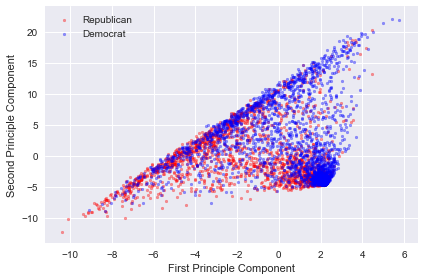

In [1182]:
X, y = process(Xtrain, ytrain, threshold=0, scale=True, dummy_na=False)
pls = PLSRegression(n_components=2)
pls.fit(MinMaxScaler().fit_transform(np.apply_along_axis(lambda x: boxcox(x)[0], 1, (X + 1).values)), y=='Republican')
plt.scatter(pls.x_scores_[np.where(ytrain=='Republican'), 0], pls.x_scores_[np.where(ytrain=='Republican'), 1], c='red', alpha=0.4, s=8, label='Republican')
plt.scatter(pls.x_scores_[np.where(ytrain=='Democrat'), 0], pls.x_scores_[np.where(ytrain=='Democrat'), 1], c='blue', alpha=0.4, s=8, label='Democrat')
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')
plt.legend()
plt.savefig('images/PLS');

Performing classification on multiple dimension derived from PLS shows no real enhancement to the score

In [1183]:
for i in range(10, 101, 10):
    pls = PLSRegression(n_components=i)
    pls.fit(MinMaxScaler().fit_transform(np.apply_along_axis(lambda x: boxcox(x)[0], 1, (X + 1).values)), y=='Republican')
    X_transformed = pls.x_scores_
    print i, np.mean(cross_val_score(SVC(), X_transformed, ytrain))

10 0.641398078287
20 0.638302702006
30 0.640043178256
40 0.638690969857
50 0.638688278225
60 0.636563795873
70 0.634825114044
80 0.630378202271
90 0.627479427243
100 0.627477632822


# Correlation Plot

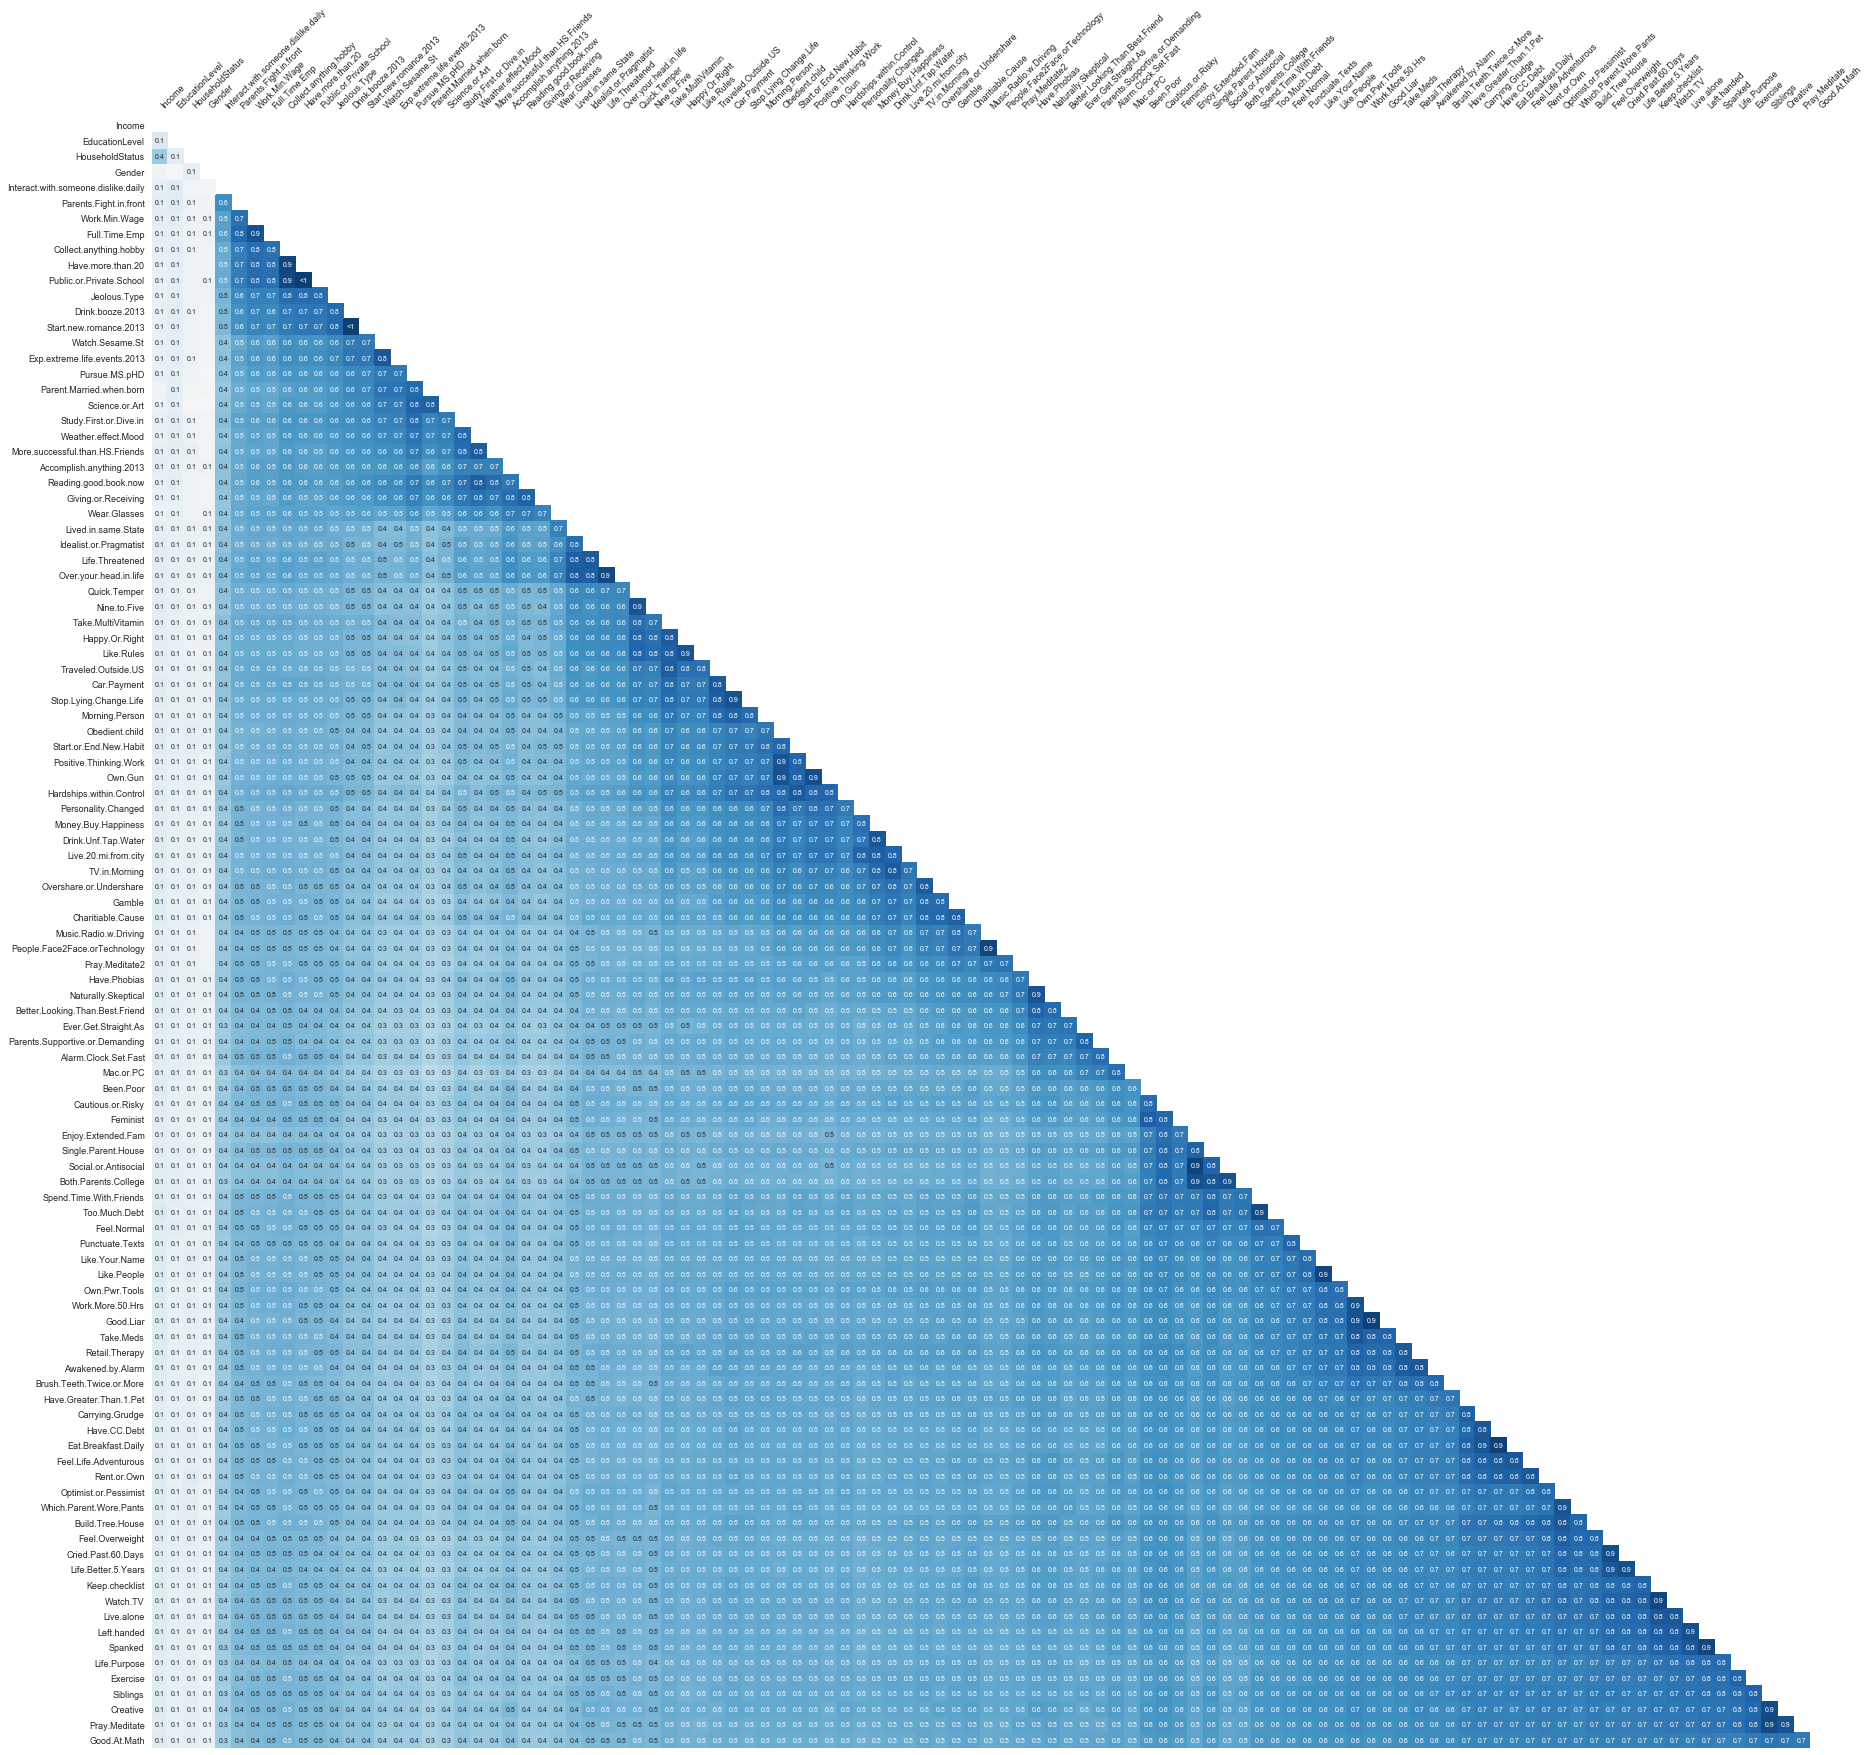

In [641]:
x = msno.heatmap(Xtrain, inline=False, figsize=(30, 30), fontsize=9)
x.savefig('images/corrmap')

# Elastic NET

In [842]:
X, y = process(Xtrain, ytrain, threshold=0.3, scale=True, dummy_na=True)
enetcv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=2)
enetcv.fit(X, y == 'Republican')

ElasticNetCV(alphas=None, copy_X=True, cv=2, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [857]:
enetcv.alphas_.min(), enetcv.alphas_.max()

(6.2665315953358227e-05, 0.62665315953358292)

In [843]:
print enetcv.l1_ratio_
print enetcv.alpha_

np.mean((enetcv.predict(X) > 0.5).astype(np.int) == (y == 'Republican').values.astype(np.int))

1.0
0.00671939642537


0.66118674544053424

In [844]:
enet_preds = np.where(enetcv.predict(process(Xtest, scale=True, dummy_na=True)) > 0.5, 'Republican', 'Democrat')
enet_preds_df = pd.DataFrame(np.array([Xtest.index, enet_preds]).T, columns=['USER_ID', 'Predictions'])
enet_preds_df.to_csv('Udacity_ENET_Preds2.csv', index=False)

# Random Forest

In [845]:
X, y = process(Xtrain, ytrain, threshold=0.3, dummy_na=True)

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": np.arange(8, 21, 2),
              "min_samples_split": np.arange(1000, 1501, 100),
              "min_samples_leaf": np.arange(1,102, 10),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
for i in range(5):
    random_search = RandomizedSearchCV(RandomForestClassifier(n_estimators=50), param_distributions=param_dist,
                                       n_iter=n_iter_search, cv=StratifiedShuffleSplit(test_size=0.2),
                                       scoring='roc_auc')
    random_search.fit(X, y == 'Republican')
    print random_search.best_score_, random_search.best_params_
    

0.70816789094 {'bootstrap': False, 'min_samples_leaf': 41, 'max_features': 18, 'criterion': 'gini', 'min_samples_split': 1200, 'max_depth': None}
0.692027661968 {'bootstrap': False, 'min_samples_leaf': 61, 'max_features': 20, 'criterion': 'entropy', 'min_samples_split': 1400, 'max_depth': 3}
0.706437032625 {'bootstrap': False, 'min_samples_leaf': 91, 'max_features': 16, 'criterion': 'gini', 'min_samples_split': 1100, 'max_depth': 3}
0.696038647343 {'bootstrap': False, 'min_samples_leaf': 101, 'max_features': 20, 'criterion': 'entropy', 'min_samples_split': 1300, 'max_depth': 3}
0.700483422672 {'bootstrap': False, 'min_samples_leaf': 101, 'max_features': 20, 'criterion': 'entropy', 'min_samples_split': 1200, 'max_depth': None}


In [911]:
X, y = process(Xtrain, ytrain, threshold=0.3, dummy_na=True)

# specify parameters and distributions to sample from
param_dist = {"n_estimators": [1000, 2000]}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_dist,
                           cv=StratifiedShuffleSplit(test_size=0.5), scoring='roc_auc')
grid_search.fit(X, y == 'Republican')
print grid_search.best_score_, grid_search.best_params_

0.700509008303 {'n_estimators': 2000}


In [912]:
rf1_submit = grid_search.best_estimator_

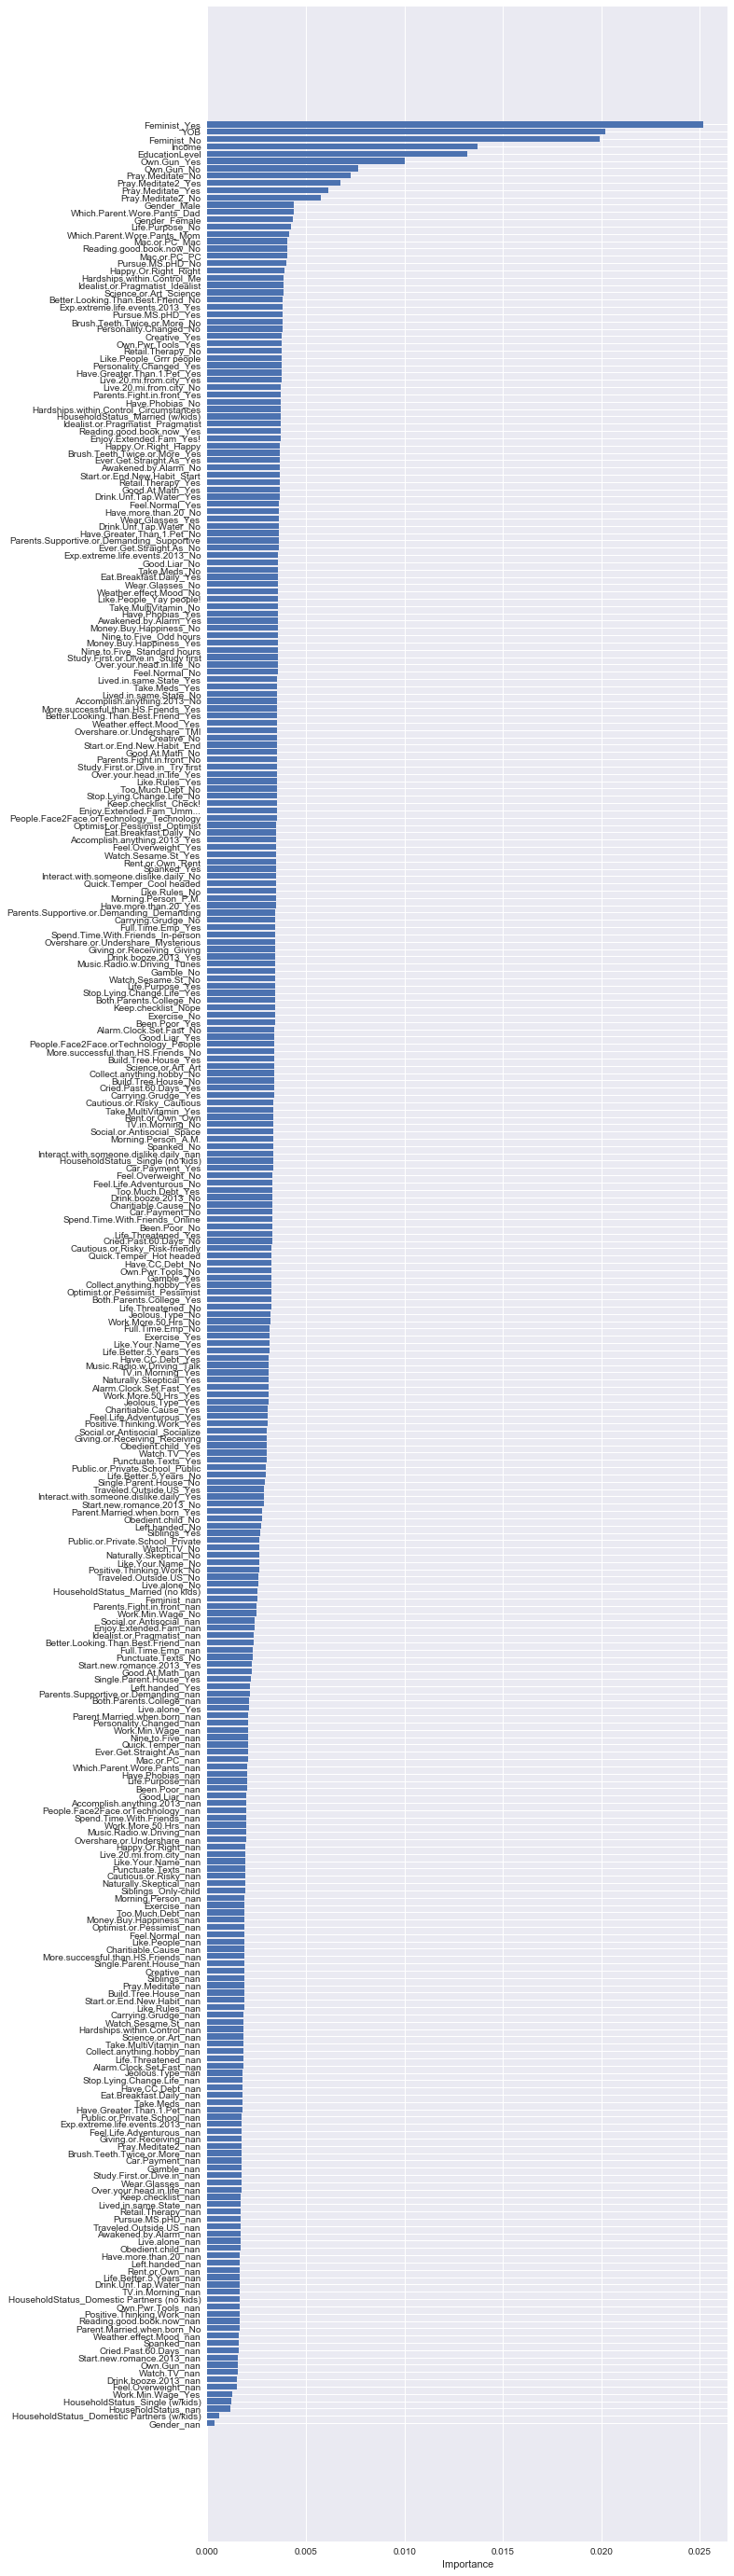

In [913]:
importances, labels = zip(*sorted(zip(rf1_submit.feature_importances_, X)))
fig, ax = plt.subplots(figsize=(10, 50))
ax.barh(np.arange(len(importances)), importances)
ax.set_yticks(np.arange(len(importances)))
ax.set_xlabel('Importance')
ax.set_yticklabels(labels);
fig.savefig('images/RF-Importances')

In [850]:
Xtest_processed = process(Xtest)
rf1_preds = rf1_submit.predict(Xtest_processed)
rf1_preds_df = pd.DataFrame(np.array([Xtest_processed.index, rf1_preds]).T, columns=['USER_ID', 'Predictions'])
rf1_preds_df.to_csv('Udacity_RF_Preds2.csv', index=False)

# Gradient Boosting

In [865]:
gbm1_param = {'min_samples_split': np.arange(1000, 2001, 100),
        'min_samples_leaf': np.arange(2, 11, 2)}
gbm1 = GradientBoostingClassifier()   

gs_gbm1 = GridSearchCV(gbm1, param_grid=gbm1_param, cv=StratifiedShuffleSplit(test_size=0.5))
gs_gbm1.fit(X, y == 'Republican')

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.5,
            train_size=None),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': array([1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]), 'min_samples_leaf': array([ 2,  4,  6,  8, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [866]:
gs_gbm1.best_params_, gs_gbm1.best_score_

({'min_samples_leaf': 6, 'min_samples_split': 1300}, 0.65495634309193629)

In [870]:
gbm2_param = {'subsample':np.arange(6, 11)/10.}
gbm2 = GradientBoostingClassifier(**gs_gbm1.best_params_)   

gs_gbm2 = GridSearchCV(gbm2, param_grid=gbm2_param, cv=StratifiedShuffleSplit(test_size=0.5))
gs_gbm2.fit(X, y == 'Republican')

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.5,
            train_size=None),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=6,
              min_samples_split=1300, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'subsample': array([ 0.6,  0.7,  0.8,  0.9,  1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [871]:
gs_gbm2.best_params_, gs_gbm2.best_score_

({'subsample': 1.0}, 0.65264509501797641)

In [901]:
gbm3_param = {'n_estimators':np.arange(50, 151, 10)}
gbm3 = GradientBoostingClassifier(**gs_gbm2.best_estimator_.get_params())   

gs_gbm3 = GridSearchCV(gbm3, param_grid=gbm3_param, cv=StratifiedShuffleSplit(test_size=0.5))
gs_gbm3.fit(X, y == 'Republican')

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.5,
            train_size=None),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=6,
              min_samples_split=1300, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [902]:
gs_gbm3.best_params_, gs_gbm3.best_score_

({'n_estimators': 80}, 0.64622496147919872)

In [905]:
Xtest_processed = process(Xtest)
gbm_preds = gs_gbm3.best_estimator_.predict(Xtest_processed)
gbm_preds_df = pd.DataFrame(np.array([Xtest_processed.index, np.where(gbm_preds, 'Republican', 'Democrat')]).T, columns=['USER_ID', 'Predictions'])
gbm_preds_df.to_csv('Udacity_GBM_Preds2.csv', index=False)

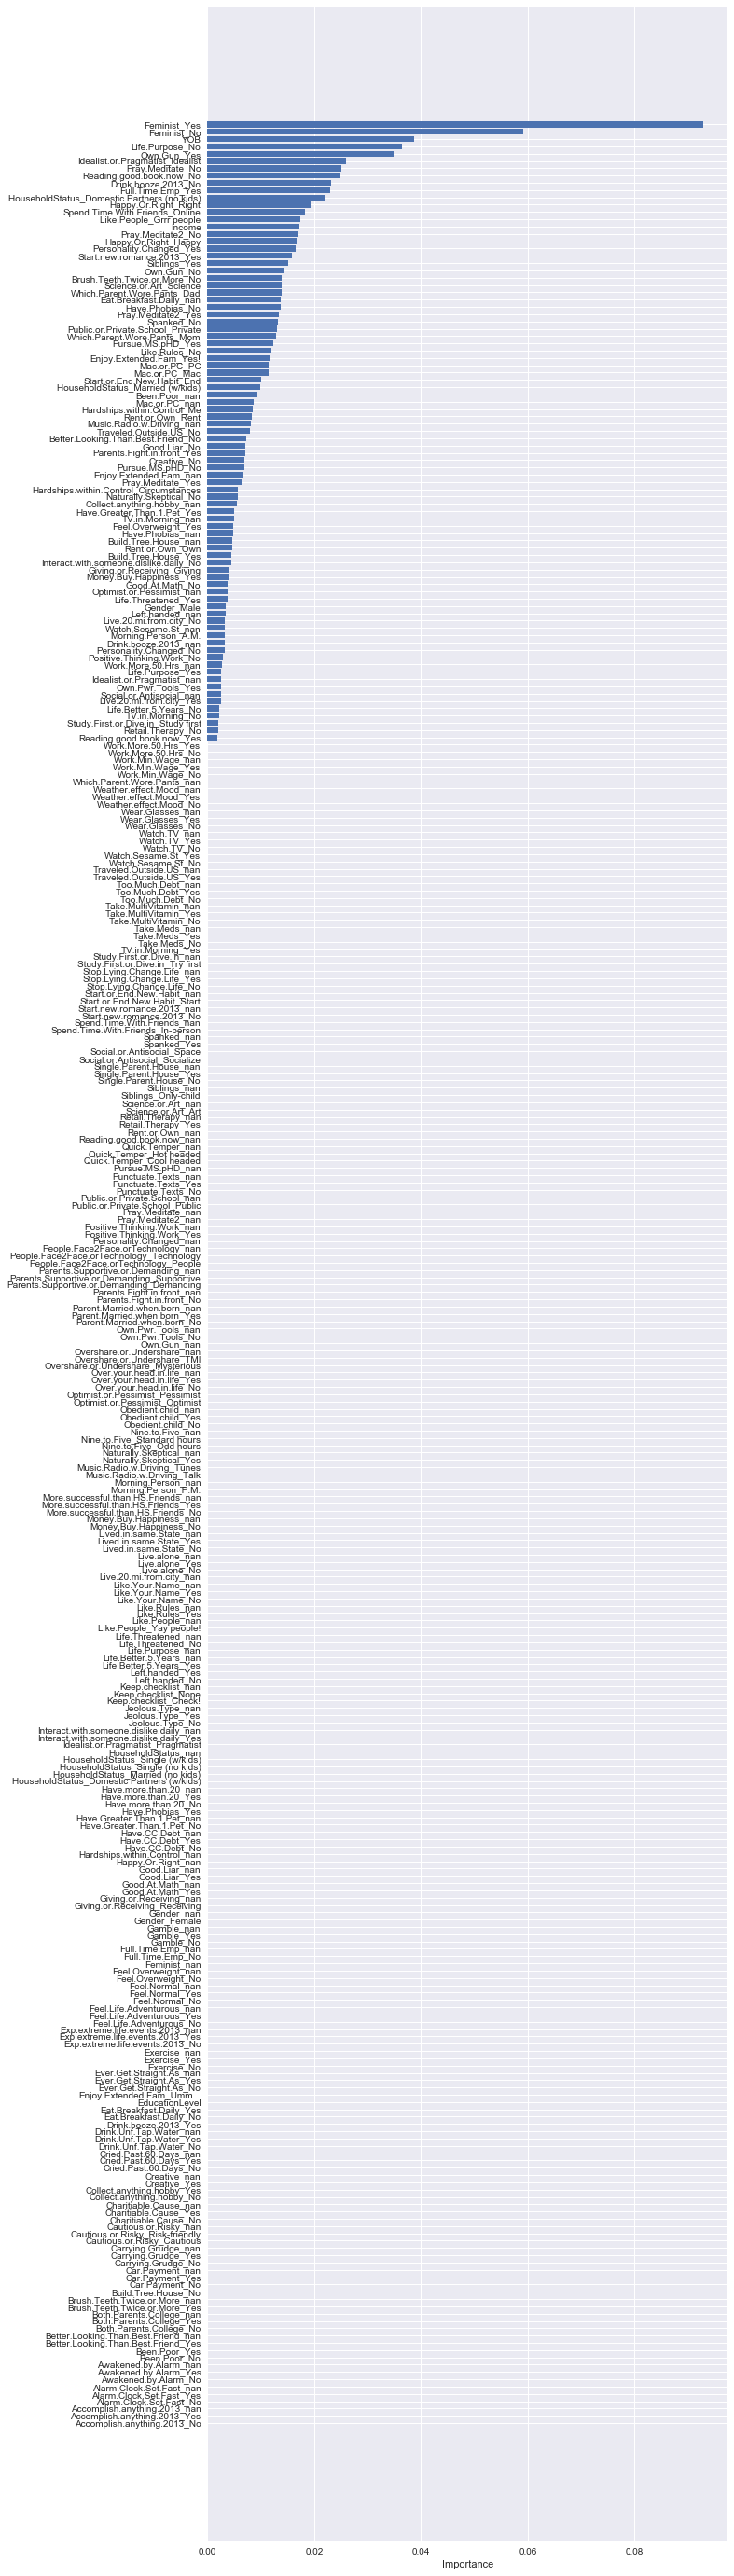

In [915]:
importances, labels = zip(*sorted(zip(gs_gbm3.best_estimator_.feature_importances_, X)))
fig, ax = plt.subplots(figsize=(10, 50))
ax.barh(np.arange(len(importances)), importances)
ax.set_yticks(np.arange(len(importances)))
ax.set_xlabel('Importance')
ax.set_yticklabels(labels)
fig.savefig('images/GBM-importances');

# Support Vector Machines

In [916]:
X, y = process(Xtrain, ytrain, threshold=0.3, scale=True, dummy_na=True)

param_grid = {'C':np.logspace(-1, 1, 3), 
              'gamma':np.logspace(-4, -2, 3)}
svc_gs = GridSearchCV(svc, param_grid=param_grid, n_jobs=-1, scoring='roc_auc', cv=StratifiedShuffleSplit(test_size=0.2))
svc_gs.fit(X, y == 'Republican')

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  0.1,   1. ,  10. ]), 'gamma': array([ 0.0001,  0.001 ,  0.01  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [917]:
svc_gs.best_params_, svc_gs.best_score_

({'C': 10.0, 'gamma': 0.0001}, 0.70297796307325799)

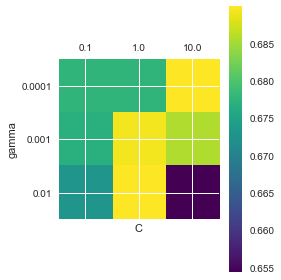

In [1041]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(svc_gs.cv_results_['mean_test_score'].reshape(3, -1).T, cmap="viridis")
ax.set_xlabel("C")
ax.set_ylabel("gamma")
ax.set_xticklabels([0] + list(param_grid['C']))
ax.set_yticklabels([0] + list(param_grid['gamma']))
fig.colorbar(ax.matshow(svc_gs.cv_results_['mean_test_score'].reshape(3, -1).T, cmap="viridis"))
#ax.tight_layout()
fig.savefig('images/svc-grid', bbox_inches='tight');

In [1037]:
svc_gs.cv_results_['mean_test_score']

array([ 0.67766319,  0.67697026,  0.67297759,  0.67769579,  0.68933158,
        0.6899515 ,  0.68994368,  0.6857561 ,  0.65441508])

In [920]:
svc_preds = np.where(svc_gs.predict(process(Xtest, scale=True, dummy_na=True)), 'Republican', 'Democrat')
svc_preds_df = pd.DataFrame(np.array([USER_ID, svc_preds]).T, columns=['USER_ID', 'Predictions'])
svc_preds_df.to_csv('Udacity_SVC_Preds2.csv', index=False)

In [619]:
Xtrain.YOB.astype(np.int).describe()

count    5173.000000
mean     1979.632708
std        14.948624
min      1935.000000
25%      1970.000000
50%      1983.000000
75%      1993.000000
max      1999.000000
Name: YOB, dtype: float64

In [631]:
ytrain.value_counts()

Democrat      2750
Republican    2423
Name: Party, dtype: int64

In [692]:
dt_param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 4],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

X, y = process(Xtrain, ytrain, threshold=0.3, scale=False, dummy_na=True)
dtclf = DecisionTreeClassifier()    
grid_search = GridSearchCV(dtclf, param_grid=dt_param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X, y).score(X, y) 

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  1.0min finished


0.64731569483688667

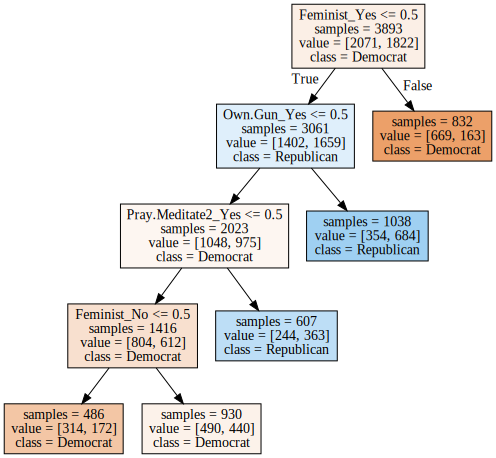

In [695]:
export_graphviz(grid_search.best_estimator_, out_file="tree.dot", 
                class_names=["Democrat", "Republican"], 
                feature_names=X.columns, 
                impurity=False, 
                filled=True)

import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [696]:
from subprocess import check_call
check_call(['dot','-Tpng','tree.dot','-o','tree.png'])

0

In [983]:
# Create meta-features
Xtrain['Yes Votes'] = (Xtrain.iloc[:, 5:] == 'Yes').sum(axis=1)
Xtest['Yes Votes'] = (Xtest.iloc[:, 5:] == 'Yes').sum(axis=1)
Xtrain['Number NAs'] = Xtrain.isnull().sum(axis=1) 
Xtest['Number NAs'] = Xtest.isnull().sum(axis=1) 

X, y = process(Xtrain, ytrain, threshold=0.3, dummy_na=True)

In [962]:
# Random Forest with Meta-Features
rf2_submit = RandomForestClassifier(n_estimators=2000).fit(X, y == 'Republican')

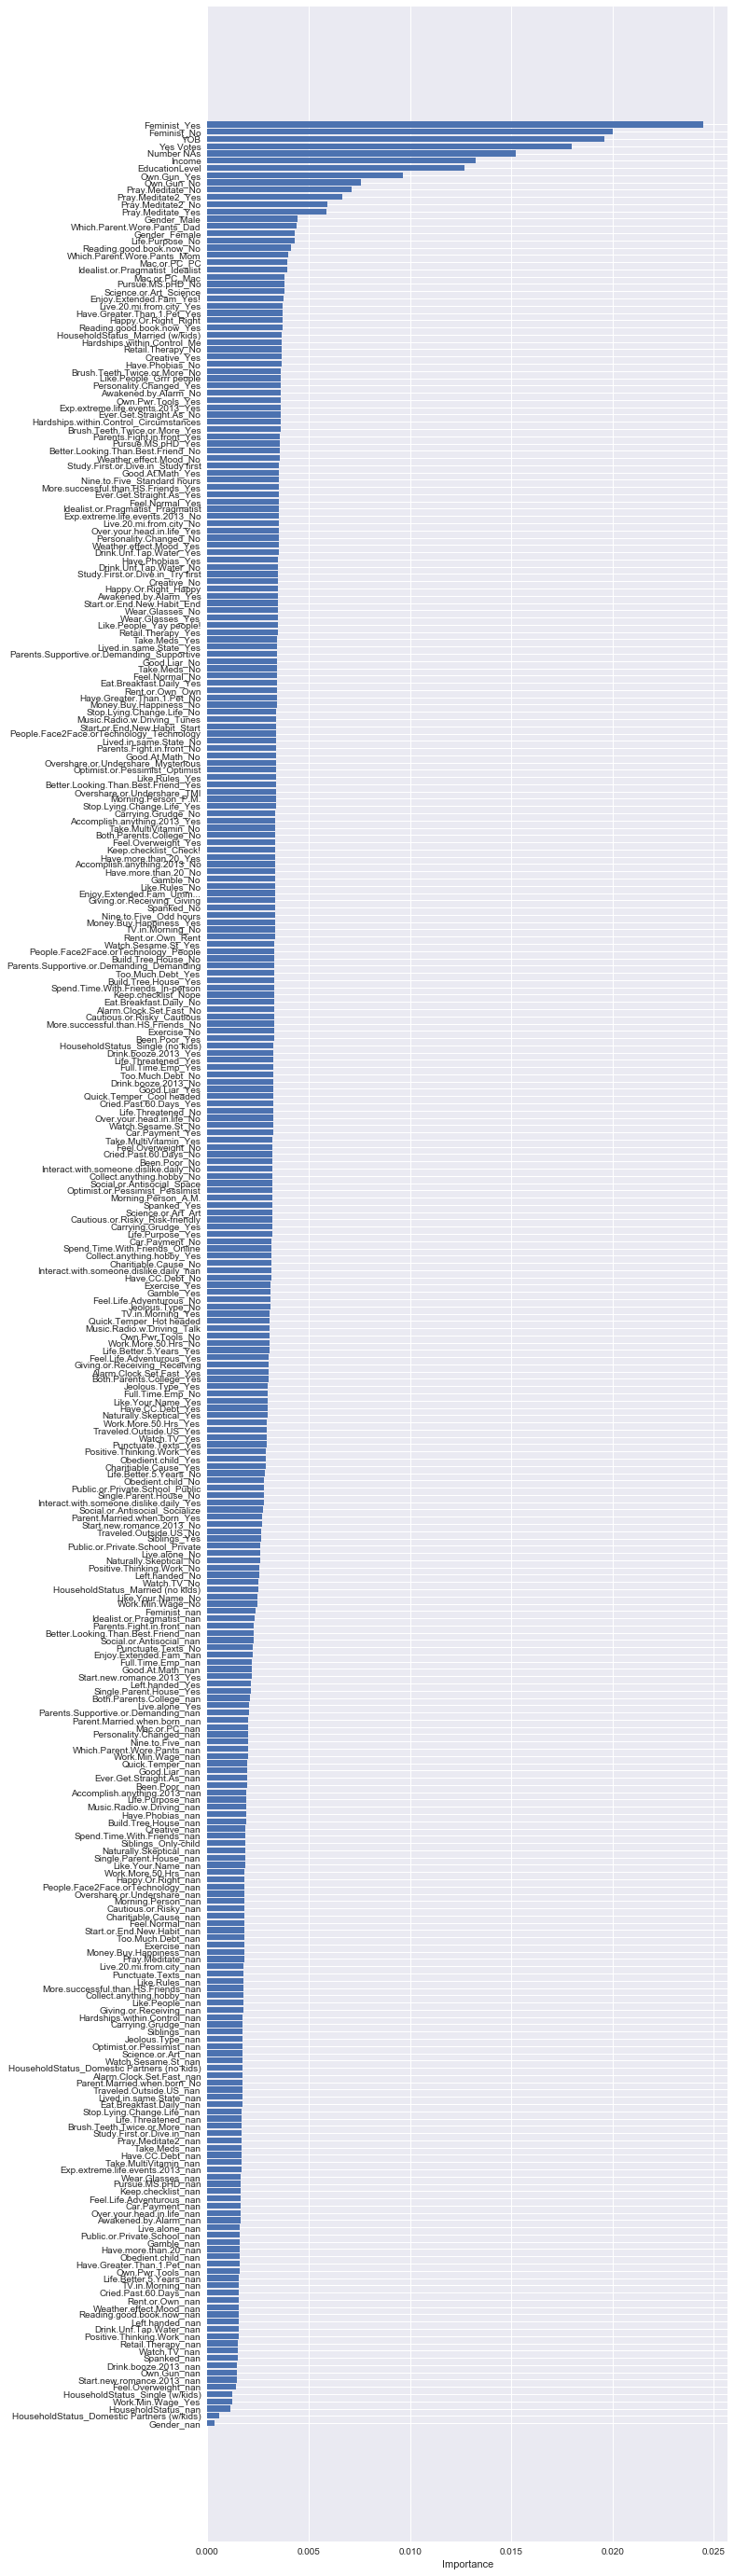

In [963]:
importances, labels = zip(*sorted(zip(rf2_submit.feature_importances_, X)))
fig, ax = plt.subplots(figsize=(10, 50))
ax.barh(np.arange(len(importances)), importances)
ax.set_yticks(np.arange(len(importances)))
ax.set_xlabel('Importance')
ax.set_yticklabels(labels);
fig.savefig('images/RF-Importances2')

In [964]:
Xtest_processed = process(Xtest)
rf2_preds = np.where(rf2_submit.predict(Xtest_processed), 'Republican', 'Democrat')
rf2_preds_df = pd.DataFrame(np.array([Xtest_processed.index, rf2_preds]).T, columns=['USER_ID', 'Predictions'])
rf2_preds_df.to_csv('Udacity_RF_Preds2.csv', index=False)

In [984]:
# Try GBM with meta features
gs_gbm3.fit(X, y == 'Republican')

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.5,
            train_size=None),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=6,
              min_samples_split=1300, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [985]:
Xtest_processed = process(Xtest)
gbm_preds = gs_gbm3.best_estimator_.predict(Xtest_processed)
gbm_preds_df = pd.DataFrame(np.array([Xtest_processed.index, np.where(gbm_preds, 'Republican', 'Democrat')]).T, columns=['USER_ID', 'Predictions'])
gbm_preds_df.to_csv('Udacity_GBM_Preds2.csv', index=False)

In [987]:
# Create meta-features
Xtrain['Yes Votes'] = MinMaxScaler().fit_transform(boxcox((Xtrain.iloc[:, 5:] == 'Yes').sum(axis=1) + 1)[0])
Xtest['Yes Votes'] = MinMaxScaler().fit_transform(boxcox((Xtest.iloc[:, 5:] == 'Yes').sum(axis=1) + 1)[0])
Xtrain['Number NAs'] = MinMaxScaler().fit_transform(boxcox(Xtrain.isnull().sum(axis=1) + 1)[0])
Xtest['Number NAs'] = MinMaxScaler().fit_transform(boxcox(Xtest.isnull().sum(axis=1) + 1)[0])

X, y = process(Xtrain, ytrain, threshold=0.3, scale=True, dummy_na=True)

/Users/Mike/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Mike/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Mike/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X

In [967]:
enet2 = ElasticNet(l1_ratio=1, alpha=0.0067)
enet2.fit(X, y == 'Republican')

ElasticNet(alpha=0.0067, copy_X=True, fit_intercept=True, l1_ratio=1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [968]:
enet2_preds = np.where(enet2.predict(process(Xtest, scale=True, dummy_na=True)) > 0.5, 'Republican', 'Democrat')
enet2_preds_df = pd.DataFrame(np.array([Xtest_processed.index, enet2_preds]).T, columns=['USER_ID', 'Predictions'])
enet2_preds_df.to_csv('Udacity_ENET_Preds2.csv', index=False)

In [988]:
svc_gs.fit(X, y == 'Republican')
svc_preds = np.where(svc_gs.predict(process(Xtest, scale=True, dummy_na=True)), 'Republican', 'Democrat')
svc_preds_df = pd.DataFrame(np.array([USER_ID, svc_preds]).T, columns=['USER_ID', 'Predictions'])
svc_preds_df.to_csv('Udacity_SVC_Preds2.csv', index=False)

In [969]:
print """enet1 =  {'L1_ratio': 1,
         'alpha': 0.0067,
         'Enet public score': 0.62500}
         
enet2 =  {'L1_ratio': 1,
         'alpha': 0.0067,
         'Enet public score': 0.61638}

rf1 = {'n_estimators': 2000, 
      'rf_public score': 0.62644}
      
rf2 = {'n_estimators': 2000, 
      'rf_public score': 0.61925}

gb =  {'max_depth': 3,
       'max_features': None,
       'min_samples_leaf': 6,
       'min_samples_split': 1300,
       'n_estimators': 80,
       'subsample': 1.0
       'gb_public score':0.62213}
       
gb2 =  {'max_depth': 3,
       'max_features': None,
       'min_samples_leaf': 6,
       'min_samples_split': 1300,
       'n_estimators': 80,
       'subsample': 1.0
       'gb_public score':0.62213}

svm =  {'C':10 ,
        'gamma':0.001 ,
       'svm_public score':0.61063}
       
svm =  {'C':10 ,
        'gamma':0.001 ,
       'svm_public score':0.62069}
       
baseline score: 0.59914
"""


enet1 =  {'L1_ratio': 1,
         'alpha': 0.0067,
         'Enet public score': 0.62500}
         
enet2 =  {'L1_ratio': 1,
         'alpha': 0.0067,
         'Enet public score': 0.61638}

rf1 = {'n_estimators': 2000, 
      'rf_public score': 0.62644}
      
rf2 = {'n_estimators': 2000, 
      'rf_public score': 0.61925}

gb =  {'max_depth': 3,
       'max_features': None,
       'min_samples_leaf': 6,
       'min_samples_split': 1300,
       'n_estimators': 80,
       'subsample': 1.0
       'gb_public score':0.62213}

svm =  {'C':10 ,
        'gamma':0.001 ,
       'svm_public score':0.61063}
       
baseline score: 0.59914

